<a href="https://colab.research.google.com/github/eglepuo/TripletNetwork/blob/master/Bakalauras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons


     |████████████████████████████████| 706kB 8.6MB/s 


In [ ]:
import json, h5py, os, shutil, sys
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image

import tensorflow as tf
from tensorflow import saved_model
from tensorflow.keras import backend, applications, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework import ops
import tensorflow_addons as tfa

import math
import os

ModuleNotFoundError: ignored

In [ ]:
def enable_gpu_memory_growth():
    """
    Enables memory groth mode for GPUs.
    """
    gpus = tf.config.experimental.list_physical_devices('GPU')
    assert len(gpus) > 0, "No GPUs detected!"
            
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# enable_gpu_memory_growth()

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow version: " + tf.__version__)

In [ ]:
checkpoint_dir = os.path.join('/content/drive/My Drive/runtime_files', 'saved_model')
checkpoint_auto_dir = os.path.join('/content/drive/My Drive/runtime_files', 'auto_saved_model.h5')
tensorboard_log_dir = os.path.join('/content/drive/My Drive/runtime_files', 'logs', str(time()))

#config = SimilarityConfigParser()

# Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
batch_size = 1
argN = 64

train_folder = '/content/drive/My Drive/final_bakalauro_data'
test_folder = '/content/drive/My Drive/final_bakalauro_data'

train_dir_anchor = os.path.join(train_folder, 'train_a')
train_dir_positive = os.path.join(train_folder, 'train_p')
train_dir_negative = os.path.join(train_folder, 'train_n_')

valid_dir_anchor = os.path.join(train_folder, 'valid_a')
valid_dir_positive = os.path.join(train_folder, 'valid_p')
valid_dir_negative = os.path.join(train_folder, 'valid_n')

test_dir_anchor = os.path.join(test_folder, 'test_a')
test_dir_positive = os.path.join(test_folder, 'test_p')
test_dir_negative = os.path.join(test_folder, 'test_n')

In [ ]:
def train_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = train_dir_anchor, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = train_dir_positive, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = train_dir_negative, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def valid_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = valid_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = valid_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = valid_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def test_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = test_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = test_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = test_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

# Loss & metric functions

In [ ]:
# def triplet_loss(N = argN, epsilon = 1e-6):
#     def triplet_loss(y_true, y_pred):
#         beta = N
#         print("Shape:", y_pred.get_shape())

#         anchor = y_pred[0::3]
#         positive = y_pred[1::3]
#         negative = y_pred[2::3]

#         positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis = 0, keepdims = True)
#         negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis = 0, keepdims = True)

#         positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
#         negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)
        
#         #positive_distance = np.nansum(np.square(anchor - positive), axis = 1)
#         #positive_distance = - np.log(- (positive_distance / beta) + 1 + epsilon)
#         #negative_distance = np.nansum(np.square(anchor - negative), axis = 1)
#         #negative_distance = - np.log(- (negative_distance / beta) + 1 + epsilon)
        
#         loss = positive_distance + negative_distance
#         #loss = tf.math.maximum(positive_distance - negative_distance + 0.5, 0)
#         return loss
#     return triplet_loss

def triplet_loss(N = argN, epsilon = 1e-6):
    def triplet_loss(y_true, y_pred):
        beta = N
        print("Shape:", y_pred.get_shape())

        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        negative = y_pred[2::3]

        positive_distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(anchor, positive), 2), 1, keepdims=True))
        negative_distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(anchor, negative), 2), 1, keepdims=True))

        loss = tf.reduce_mean(tf.maximum(positive_distance - negative_distance + 0.5, 0))
        return loss
    return triplet_loss

In [ ]:
def pd(N = argN, epsilon = 1e-6):
    def pd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis=0)
        #positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
        return backend.mean(positive_distance)
    return pd

def nd(N = argN, epsilon = 1e-06):
    def nd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        negative = y_pred[2::3]
        negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis=0)
        #negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)
        return backend.mean(negative_distance)
    return nd

# Defining the model

In [ ]:
def make_model():
    input_a = Input(shape = (224, 224, 3),  name = 'input_a')
    input_p = Input(shape = (224, 224, 3),  name = 'input_p')
    input_n = Input(shape = (224, 224, 3),  name = 'input_n')

    base_model = applications.VGG16(include_top = False, weights = 'imagenet')

    l1_a = base_model.layers[0](input_a)
    l1_p = base_model.layers[0](input_p)
    l1_n = base_model.layers[0](input_n)

    l2_a = base_model.layers[1](l1_a)
    l2_p = base_model.layers[1](l1_p)
    l2_n = base_model.layers[1](l1_n)

    l3_a = base_model.layers[2](l2_a)
    l3_p = base_model.layers[2](l2_p)
    l3_n = base_model.layers[2](l2_n)

    l4_a = base_model.layers[3](l3_a)
    l4_p = base_model.layers[3](l3_p)
    l4_n = base_model.layers[3](l3_n)

    l5_a = base_model.layers[4](l4_a)
    l5_p = base_model.layers[4](l4_p)
    l5_n = base_model.layers[4](l4_n)

    l6_a = base_model.layers[5](l5_a)
    l6_p = base_model.layers[5](l5_p)
    l6_n = base_model.layers[5](l5_n)

    l7_a = base_model.layers[6](l6_a)
    l7_p = base_model.layers[6](l6_p)
    l7_n = base_model.layers[6](l6_n)

    l8_a = base_model.layers[7](l7_a)
    l8_p = base_model.layers[7](l7_p)
    l8_n = base_model.layers[7](l7_n)

    l9_a = base_model.layers[8](l8_a)
    l9_p = base_model.layers[8](l8_p)
    l9_n = base_model.layers[8](l8_n)

    # l10_a = base_model.layers[9](l9_a)
    # l10_p = base_model.layers[9](l9_p)
    # l10_n = base_model.layers[9](l9_n)

    # l11_a = base_model.layers[10](l10_a)
    # l11_p = base_model.layers[10](l10_p)
    # l11_n = base_model.layers[10](l10_n)

    # l12_a = base_model.layers[11](l11_a)
    # l12_p = base_model.layers[11](l11_p)
    # l12_n = base_model.layers[11](l11_n)

    # l13_a = base_model.layers[12](l12_a)
    # l13_p = base_model.layers[12](l12_p)
    # l13_n = base_model.layers[12](l12_n)

    # l14_a = base_model.layers[13](l13_a)
    # l14_p = base_model.layers[13](l13_p)
    # l14_n = base_model.layers[13](l13_n)

    # l15_a = base_model.layers[14](l14_a)
    # l15_p = base_model.layers[14](l14_p)
    # l15_n = base_model.layers[14](l14_n)

    # l16_a = base_model.layers[15](l15_a)
    # l16_p = base_model.layers[15](l15_p)
    # l16_n = base_model.layers[15](l15_n)

    # l17_a = base_model.layers[16](l16_a)
    # l17_p = base_model.layers[16](l16_p)
    # l17_n = base_model.layers[16](l16_n)

    lt1 = Dense(64, activation = 'sigmoid')
    lt2 = Dropout(0.5)
    lt3 = Dense(8, activation = 'sigmoid')

    lt1_a = lt1(l9_a)
    lt1_p = lt1(l9_p)
    lt1_n = lt1(l9_n)

    lt2_a = lt2(lt1_a)
    lt2_p = lt2(lt1_p)
    lt2_n = lt2(lt1_n)

    lt3_a = lt3(lt2_a)
    lt3_p = lt3(lt2_p)
    lt3_n = lt3(lt2_n)

    output = tf.keras.layers.concatenate([lt3_a, lt3_p, lt3_n], axis = 0, name = 'out666')
    model = tf.keras.models.Model(inputs = [input_a, input_p, input_n], outputs = output)

    for layer in model.layers:
        if layer.name == 'dense':
            break
        layer.trainable = False

    model.compile(optimizer = optimizers.Adam(), loss = triplet_loss(), metrics = [pd(), nd()])

    return model


# Training

In [ ]:
def plot_metrics(history, metrics=['loss'], skip_start=0.):
    """
    Plots metrics from keras training history.
    """
    hist = history.history
    start_indice = int(len(hist[metrics[0]]) * skip_start)
    
    for metric in metrics:
        plt.plot(hist[metric][start_indice:], label="train {}".format(metric))
        plt.plot(hist[f"val_{metric}"][start_indice:], label=f"val {metric}")
        plt.legend()
        plt.title(metric)
        plt.figure()
    
    plt.show()

Training loop

Setting up the callbacks. Added 2 additional callbacks for training:
  - `EarlyStopping` - stops the model once it's no longer getting better at validation data
  - `ReduceLROnPlateau` - reduces learning rate when model doesn't improve on the validation data for some period

In [ ]:
callbacks = [
#     TensorBoard(log_dir = tensorboard_log_dir, histogram_freq = 2, write_graph = True, write_images = True),
#     ModelCheckpoint(checkpoint_auto_dir, save_weights_only = False, period = 100, verbose = 1),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
model = make_model()
history = model.fit_generator(
    generator = train_generator_triplet(), 
    steps_per_epoch = 1188, 
    epochs = 16, 
    validation_data = valid_generator_triplet(), 
    validation_steps = 100, 
    callbacks = callbacks,
    shuffle = False
)

NameError: ignored

In [ ]:
plot_metrics(history, metrics=['loss',], skip_start=0.0)


In [ ]:
model.save('/content/drive/My Drive/runtime_files/model.h5')


In [ ]:
model = make_model()
model.load_weights('/content/drive/My Drive/runtime_files/model56.h5')



```
# This is formatted as code
```

`test_model` function not fixed yet

In [ ]:
test_samples = len(os.listdir(os.path.join(test_dir_anchor, "0")))
results = model.predict_generator(generator = test_generator_triplet(), steps = test_samples, verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.


In [ ]:
results_images = results[0,:,:,:]
print(results_images)
print(results_images.shape)
for i in range(8):
    plt.imshow(results_images[:,:,i])
    plt.show()

#plt.imshow(results_images)

In [ ]:
anchor = results[0::3]
positive = results[1::3]
negative = results[2::3]

def print_results(index, anchor, positive, negative):
    for embedding_index in range(1):
        print("Showing triplet embedding: {}".format(embedding_index))
        print(index)
        plt.imshow(anchor[index,:,:,embedding_index])
        plt.show()
        plt.imshow(positive[index,:,:,embedding_index])
        plt.show()
        plt.imshow(negative[index,:,:,embedding_index])
        plt.show()

print_results(8, anchor, positive, negative)


(64, 56, 56, 8)
Image: 0: 2031.0931 	 4954.414
Image: 1: 2122.96 	 5921.409
Image: 2: 2114.465 	 5462.425
Image: 3: 2025.1476 	 4863.015
Image: 4: 1689.9541 	 5213.389
Image: 5: 1496.8867 	 5665.338
Image: 6: 1442.7769 	 6313.6753
Image: 7: 1400.8667 	 6368.617
Image: 8: 1373.0195 	 6448.1885
Image: 9: 1424.5686 	 6816.365
Image: 10: 1399.7272 	 7262.7275
Image: 11: 1317.2876 	 4400.833
Image: 12: 1139.9604 	 5189.8047
Image: 13: 1031.4603 	 3412.862
Image: 14: 1026.4255 	 6709.228
Image: 15: 1137.3186 	 4368.425
Image: 16: 1184.8116 	 5368.6616
Image: 17: 1253.513 	 4811.2603
Image: 18: 1287.4827 	 5988.0527
Image: 19: 1407.0494 	 5270.4375
Image: 20: 1521.8008 	 5204.0654
Image: 21: 1638.6974 	 5578.3066
Image: 22: 1564.6177 	 6023.6553
Image: 23: 1811.4618 	 3029.3623
Image: 24: 1782.5304 	 7766.1826
Image: 25: 1598.367 	 2910.5923
Image: 26: 1751.4014 	 3876.3352
Image: 27: 1867.7241 	 4013.2122
Image: 28: 1981.261 	 4130.8877
Image: 29: 1974.2893 	 7038.5513
Image: 30: 2108.441 	 

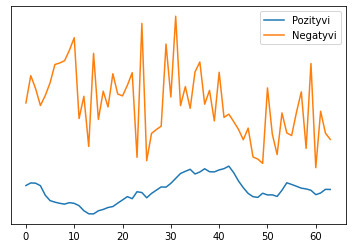

In [ ]:
beta = argN
epsilon = 1e-6

anchor = results[0::3]
positive = results[1::3]
negative = results[2::3]

print(np.square(anchor - negative).shape)

positive_distance = np.nansum(np.square(anchor - positive), axis = 1)
negative_distance = np.nansum(np.square(anchor - negative), axis = 1)


tp = 0
fp = 0
pneq = 0
min_p = sys.maxsize
max_p = 0
min_n = sys.maxsize
max_n = 0


pd_list = []
nd_list = []

normalized_pd_list = []
normalized_nd_list = []

for i in range(test_samples):
    pda = np.nansum(positive_distance[i])
    nda = np.nansum(negative_distance[i])
    
    pd_list.append(pda)
    nd_list.append(nda)

    for pd, nd in zip(pd_list, nd_list):
      # Max diff between 8 images of size 56*56 (network output)
      pda = pd / 9408
      nda = nd / 9408

    normalized_pd_list.append(pda)
    normalized_nd_list.append(nda)

    print("Image: {}:".format(i), pda, "\t", nda)

    if pda >= 0.25:
        fp += 1
    else:
        tp += 1
    if pda == nda:
        pneq += 1

    if min_p > pda:
        min_p = pda
    if max_p < pda:
        max_p = pda

    if min_n > nda:
        min_n = nda
    if max_n < nda:
        max_n = nda


plt.yticks(np.arange(0, 1.1, step=0.1))
plt.plot(normalized_pd_list, label="Pozityvi")
plt.plot(normalized_nd_list, label="Negatyvi")
plt.legend()

# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.plot(normalized_pd_list)
# plt.plot(normalized_nd_list)

print(min_p, ' - ', max_p, ', ', min_n, ' - ', max_n)
print('accuracy: ', np.round(tp / (tp + fp) * 100, 1))
print('equal predictions: ', pneq)